# Prediction of logP values from chemical structures

logP is the log of the partition coefficient, which describes the proportion of a chemical which will be found in a hydrophobic phase (1-octonol) vs a hydrophillic phase (water). The measure is very useful in the prediction of where a chemical will go in a biological or environmental system. For example, in animals, blood carries hydrophillic materials throughout the body, but without other transport mechanisms, the chemical must also be able to pass through the hydrophobic phospholipid membrane to enter cells.
https://en.wikipedia.org/wiki/Partition_coefficient#Partition_coefficient_and_log_P

This image shows a selection of chemicals comparing experimental partition between brain/blood and octonol/water showing a relatively high correlation for chemicals without an explicit transporter or efflux mechanism.

log P (octanol/water) at the X-axis vers. log Pc (permeability coefficient of rat brain capillaries in cm per second) for various drugs, solvents and other compounds. Data taken from N. Bodor and P. Buchwald: Recent advances in the brain targeting of neuropharmaceuticals by chemical delivery systems. In: Adv Drug Deliv Rev 36, 1999, pp. 229-254.

## Goal

The goal of this project is to create a system that can take an arbitrary chemical as input and predict a probable logP value from it. This will allow us to make some predications about the properties of this chemical, its suitability for use as a drug and possible environmental fate.
Methods for estimating logP from chemical structures do exist and will be used for reference to see if the machine learning methods explored will improve on the predictions.

# Data

In [1]:
import matplotlib.pyplot as pyplot
import numpy as np
import pandas as pd

Data collected from https://www.kaggle.com/matthewmasters/chemical-structure-and-logp 
This two column dataset contains only stereoscopic SMILES (https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) encoded chemical structures and experimental logP values.

In [2]:
logP = pd.read_csv('/data/logP_dataset.csv')
logP.head()

,smiles,logp
0,C[C@H]([C@@H](C)Cl)Cl,2.3
1,C(C=CBr)N,0.3
2,CCC(CO)Br,1.3
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0
4,CCCOCCP,0.6


create 3d chemical structures from the SMILES strings. Functional code was abstracted out into a separate file for reusability.

In [ ]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors

def chem_3d(mol):
    try:
        mol.UpdatePropertyCache()
        mol = Chem.AddHs(mol)
        # seed is necessary to ensure that 3d coordinates are the same for testing
        Chem.EmbedMolecule(mol, randomSeed=0xf00d)
        return mol
    except Exception as e:
        print(e)
        pass
    return None

logP['molecule'] = logP['smiles'].apply(lambda smiles: chem_3d(Chem.MolFromSmiles(smiles)))

In [4]:
logP.head()

,smiles,logp,molecule
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7f9a1d93c520>
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7f9a1d1cb700>
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7f9a1d1cb760>
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,<rdkit.Chem.rdchem.Mol object at 0x7f9a1d1cb7c0>
4,CCCOCCP,0.6,<rdkit.Chem.rdchem.Mol object at 0x7f9a1d1cb820>


After conversion, check to ensure that there is usable data for all records in the data set

In [5]:
logP.isna().sum()

smiles      0
logp        0
molecule    0
dtype: int64

There are no missing data points. If there had been, rows would have been dropped. Acurate logP values could not be engineered or filled in.

Generate 3d descriptor fingerprints.

These fingerprints should track each heavy atom and fingerprint its 3d connections to others. While the fingerprint will not contain all conformer information, it should give a reasonable representation of the functional structures of each chemical.

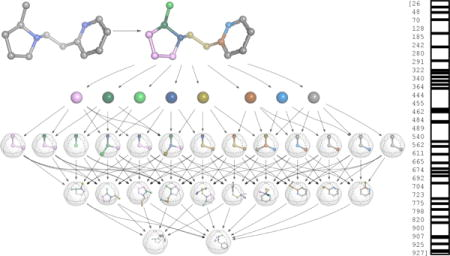

In [6]:
from e3fp.fingerprint.fprint import Fingerprint

logP['fingerprint'] = logP['molecule'].apply(lambda mol: Fingerprint.from_rdkit(Chem.GetMorganFingerprintAsBitVect(mol, 2)))

Display the fit of the rdkit generated logP value vs the experimental data from the dataset. Rdkit uses the Wildman-Crippen method.

In [7]:
logP['rdkit_logp'] = logP['molecule'].apply(Descriptors.MolLogP)

In [8]:
from e3fp.fingerprint.metrics.array_metrics import tanimoto

from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [12]:
import pickle

with open('logp.p', mode='wb') as file:
    pickle.dump(logP, file)

References:

Axen SD, Huang XP, Caceres EL, Gendelev L, Roth BL, Keiser MJ. A Simple Representation Of Three-Dimensional Molecular Structure. J. Med. Chem. 60 (17): 7393–7409 (2017).

N. Bodor and P. Buchwald: Recent advances in the brain targeting of neuropharmaceuticals by chemical delivery systems. In: Adv Drug Deliv Rev 36, 1999, pp. 229-254.

Prediction of Physicochemical Parameters by Atomic Contributions
Scott A. Wildman and Gordon M. Crippen
Journal of Chemical Information and Computer Sciences 1999 39 (5), 868-873
DOI: 10.1021/ci990307l